# Hourly Energy Consumption

The open data set we're using for this demonstration is the hourly power consumption data comes from PJM's website and are in megawatts (MW).

###### (https://github.com/buds-lab/the-building-data-genome-project)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
#import xgboost as xgb
import os

In [3]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
#from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

#### Data
##### Energy Consumption data
We will use hourly power consumption data from PJM East, it contain data from 2002-2018 for the entire east region.

In [4]:
os.getcwd() # Get current work directory 

'C:\\Users\\azeem\\Documents\\MIE_2.02_GeoInfo_WS2019\\gi0301_ALS_DTM_NRW'

In [5]:
os.chdir('C:\\Users\\azeem\\Documents\\GitHub Repositories\\Energy-Consumption-Predictions-Analysis')  # Provide the new path here

In [11]:
pjme_df = pd.read_csv('data/PJM/hourly-energy-consumption/PJME_hourly.csv', parse_dates=[0], index_col=[0])
pjme_df = pjme_df.loc[~pjme_df.index.duplicated(keep='first')].sort_index().dropna()
pjme_df.head() # top 5 rows

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


##### Dimensionality of the DataFrame
Return a tuple representing the dimensionality of the DataFrame.

In [7]:
pjme_df.shape 

(145362, 1)

##### Generate summarize descriptive Statistics
###### pandas.DataFrame.describe
Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [8]:
pjme_df.describe()

,PJME_MW
count,145362.000000
mean,32080.505139
std,6463.874131
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


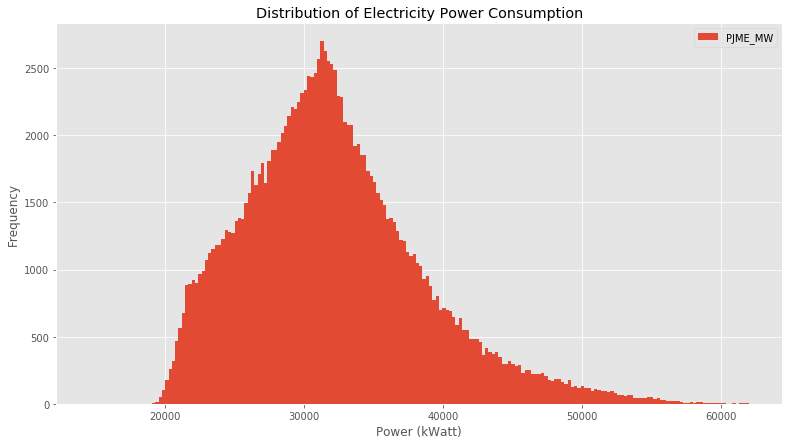

In [9]:
gp = pjme_df.plot.hist(figsize=(13, 7), bins=200, title='Distribution of Electricity Power Consumption')
plt.xlabel('Power (kWatt)')
plt.show()

##### View City Aattributes CSV files

In [47]:
city_attributes = pd.read_csv('data/PJM/historical-hourly-weather-data/humidity.csv', nrows= 0)
city_attributes

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem


#### Weather Data

In [48]:
city = 'New York'
humidity = pd.read_csv('data/PJM/historical-hourly-weather-data/humidity.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('humidity')
pressure = pd.read_csv('data/PJM/historical-hourly-weather-data/pressure.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('pressure')
temperature = pd.read_csv('data/PJM/historical-hourly-weather-data/temperature.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('temperature')
wind_direction = pd.read_csv('data/PJM/historical-hourly-weather-data/wind_direction.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('wind_direction')
wind_speed = pd.read_csv('data/PJM/historical-hourly-weather-data/wind_speed.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('wind_speed')

In [49]:
humidity.head()

datetime
2012-10-01 13:00:00    58.0
2012-10-01 14:00:00    57.0
2012-10-01 15:00:00    57.0
2012-10-01 16:00:00    57.0
2012-10-01 17:00:00    57.0
Name: humidity, dtype: float64

In [50]:
temperature.head()

datetime
2012-10-01 13:00:00    288.220000
2012-10-01 14:00:00    288.247676
2012-10-01 15:00:00    288.326940
2012-10-01 16:00:00    288.406203
2012-10-01 17:00:00    288.485467
Name: temperature, dtype: float64

#### Combine Power and weather data

In [52]:
weather_df = pd.concat([temperature, humidity, pressure, wind_direction, wind_speed], axis=1).sort_index()
weather_df = weather_df.loc[~weather_df.index.duplicated(keep='first')].sort_index().dropna()
weather_df = weather_df.assign(pressure_log = weather_df.pressure.apply(np.log))
weather_df.head()

,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log
datetime,,,,,,
2012-10-01 13:00:00,288.220000,58.0,1012.0,260.0,7.0,6.919684
2012-10-01 14:00:00,288.247676,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 15:00:00,288.326940,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 16:00:00,288.406203,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 17:00:00,288.485467,57.0,1012.0,261.0,6.0,6.919684


In [54]:
comb_df = pd.concat([pjme_df.loc[weather_df.index[0]:weather_df.index[-1]], weather_df], axis=1).sort_index().dropna()

comb_df.head()

,PJME_MW,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log
2012-10-01 13:00:00,30231.0,288.220000,58.0,1012.0,260.0,7.0,6.919684
2012-10-01 14:00:00,30461.0,288.247676,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 15:00:00,30553.0,288.326940,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 16:00:00,30562.0,288.406203,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 17:00:00,30640.0,288.485467,57.0,1012.0,261.0,6.0,6.919684


In [55]:
comb_df.tail()

,PJME_MW,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log
2017-10-27 20:00:00,29047.0,289.98,36.0,1019.0,0.0,3.0,6.926577
2017-10-27 21:00:00,28316.0,289.48,38.0,1019.0,0.0,1.0,6.926577
2017-10-27 22:00:00,27246.0,287.92,54.0,1019.0,196.0,2.0,6.926577
2017-10-27 23:00:00,25616.0,285.83,62.0,1020.0,171.0,3.0,6.927558
2017-10-28 00:00:00,23912.0,284.98,58.0,1020.0,0.0,2.0,6.927558


#### Power and weather data visualization

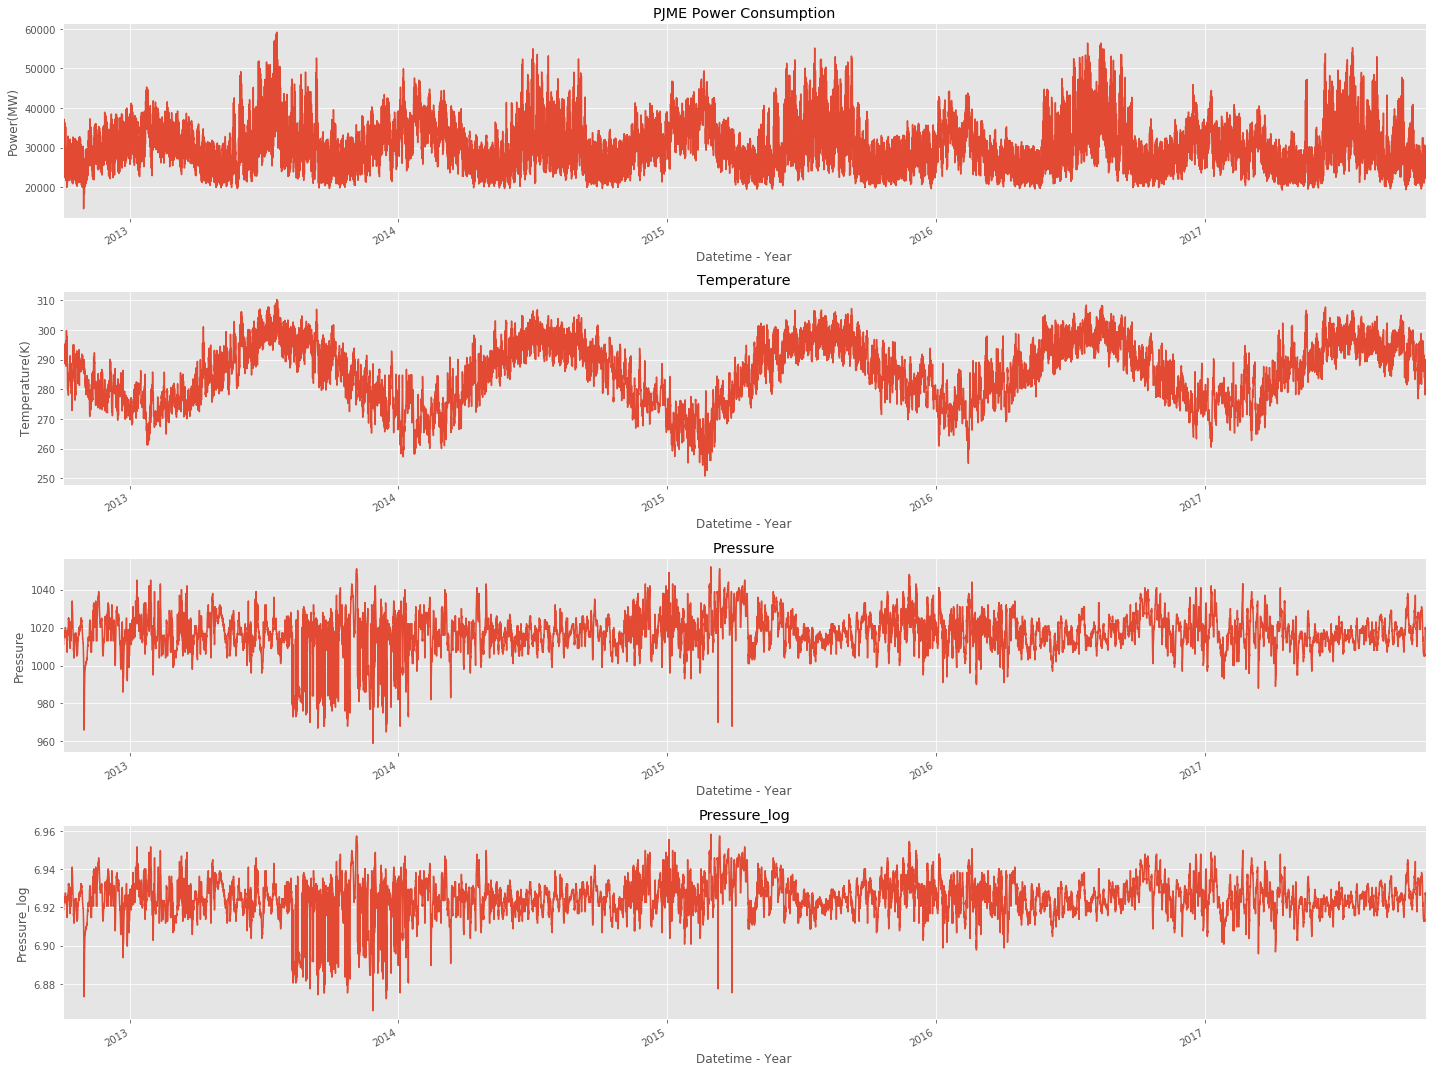

In [57]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,15))
axes[0].set_title('PJME Power Consumption')
axes[0].set_ylabel('Power(MW)')
axes[0].set_xlabel('Datetime - Year')
comb_df.PJME_MW.plot(ax=axes[0])

axes[1].set_title('Temperature')
axes[1].set_ylabel('Temperature(K)')
axes[1].set_xlabel('Datetime - Year')
comb_df.temperature.plot(ax=axes[1])

axes[2].set_title('Pressure')
axes[2].set_ylabel('Pressure')
axes[2].set_xlabel('Datetime - Year')
comb_df.pressure.plot(ax=axes[2])

axes[3].set_title('Pressure_log')
axes[3].set_ylabel('Pressure_log')
axes[3].set_xlabel('Datetime - Year')
comb_df.pressure_log.plot(ax=axes[3])

plt.tight_layout()
plt.show()

#### Time series features